C:\Users\12914\AppData\Local\Temp\ipykernel_19312\1470290817.py:37: FutureWarning: 'Q-DEC' is deprecated and will be removed in a future version, please use 'QE-DEC' instead.
  quarterly_dates = pd.date_range(start=f"{start_year}-01-01", end=f"{end_year}-12-31", freq='Q-DEC')
c:\Users\12914\anaconda3\envs\policy_analyse\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\12914\anaconda3\envs\policy_analyse\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\12914\anaconda3\envs\policy_analyse\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\12914\AppData\Local\Temp

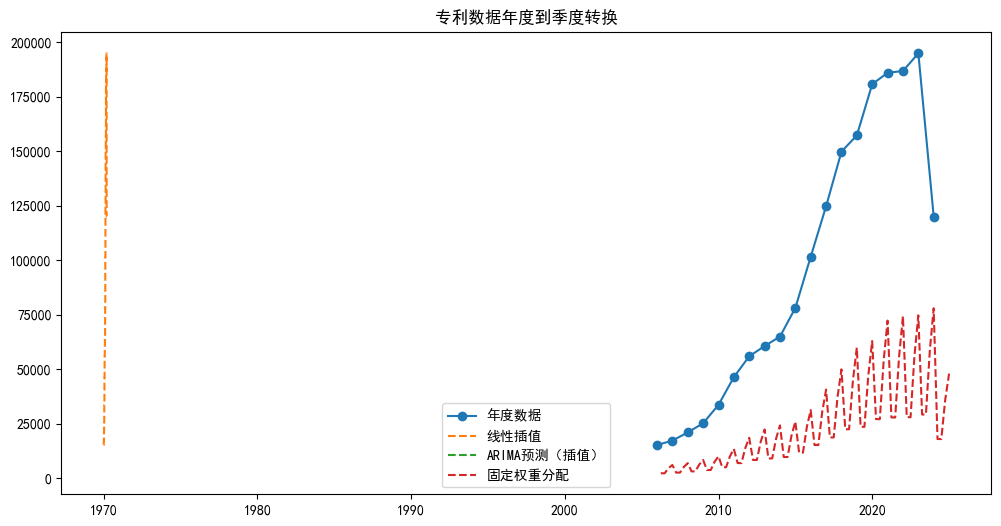

线性插值数据平稳性检验：
ADF统计量: -1.2375429404903389, p-value: 0.6572408673145256
ARIMA预测数据样本不足，跳过 ACF/PACF 绘制。
固定权重分配后的季度数据已保存至: ../data/new_found/新能源汽车相关核心专利数据/quarterly_patent_weighted.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib
# 设置绘图风格
# 设置中文字体和允许负号显示
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['axes.unicode_minus'] = False
# --- 1. 加载并预处理年度专利数据 ---
def load_and_preprocess_patent_data():
    """
    加载专利数据并设置时间索引
    :return: 年度专利数据的DataFrame
    """
    data_path = '../data/new_found/新能源汽车相关核心专利数据/智慧芽专利数据库-申请量随时间如何变化-20250320.xlsx'
    patent_data = pd.read_excel(data_path)
    # 假设 Excel 包含 '申请年 / 状态'（年份）和 '申请'（专利数量）两列
    patent_df = patent_data.set_index('申请年 / 状态')[['申请']].rename(columns={'申请': 'Patent'})
    patent_df.index = pd.to_datetime(patent_df.index.astype(str), format='%Y')
    # 添加年份列，便于后续操作
    patent_df['Year'] = patent_df.index.year
    return patent_df

# --- 2. 方法1：线性插值法 ---
def annual_to_quarterly_linear(annual_df):
    """
    将年度数据通过线性插值转换为季度数据
    :param annual_df: 年度专利数据的DataFrame
    :return: 季度专利数据的Series
    """
    start_year = annual_df.index.min().year
    end_year = annual_df.index.max().year
    # 使用统一的 freq 'Q-DEC'
    quarterly_dates = pd.date_range(start=f"{start_year}-01-01", end=f"{end_year}-12-31", freq='Q-DEC')
    
    quarterly_df = pd.DataFrame(index=quarterly_dates)
    quarterly_df['Year'] = quarterly_df.index.year
    quarterly_df = quarterly_df.merge(annual_df[['Patent','Year']], on='Year', how='left')
    quarterly_df['Patent'] = quarterly_df['Patent'].interpolate(method='linear')
    return quarterly_df['Patent']

# --- 3. 方法2：ARIMA预测法（采用 ARIMA(0,1,0)） ---
def annual_to_quarterly_arima(annual_df):
    """
    使用简单的 ARIMA(0,1,0) 模型对历史年度数据进行拟合，
    然后将预测结果转换为季度数据（线性插值填补缺失值）。
    :param annual_df: 年度专利数据的DataFrame
    :return: 季度专利数据的Series
    """
    model = ARIMA(annual_df['Patent'], order=(0, 1, 0))
    model_fit = model.fit()
    annual_pred = model_fit.predict(start=0, end=len(annual_df)-1)
    annual_pred.index = annual_df.index
    quarterly_dates = pd.date_range(start=annual_df.index.min(), end=annual_df.index.max(), freq='Q-DEC')
    quarterly_arima = annual_pred.reindex(quarterly_dates).interpolate(method='linear', limit_direction='both')
    return quarterly_arima

# --- 4. 方法4：固定权重分配法 ---
def annual_to_quarterly_weighted(annual_df):
    """
    根据固定权重（Q1:15%, Q2:15%, Q3:30%, Q4:40%）将年度专利数据分配为季度数据
    :param annual_df: 年度专利数据的DataFrame
    :return: 季度专利数据的Series
    """
    # 使用统一的 freq 'Q-DEC'
    quarterly_dates = pd.date_range(start=f"{annual_df.index.min().year}-01-01",
                                    end=f"{annual_df.index.max().year}-12-31", freq='Q-DEC')
    quarterly_series = pd.Series(index=quarterly_dates, dtype=float)
    weights = [0.15, 0.15, 0.30, 0.40]  # 固定权重
    for year in sorted(annual_df.index.year.unique()):
        df_year = annual_df[annual_df.index.year == year]
        if df_year.empty:
            continue
        # 取该年的最后一个数据作为年度总量
        annual_val = df_year['Patent'].iloc[-1]
        dates = pd.date_range(start=f"{year}-01-01", end=f"{year}-12-31", freq='Q-DEC')
        if len(dates) == 4:
            quarterly_values = [annual_val * w for w in weights]
            quarterly_series.loc[dates] = quarterly_values
    quarterly_series.name = "Patent"  # 设置名称，便于后续处理
    return quarterly_series

# --- 5. 结果可视化与验证 ---
def visualize_and_validate(annual_df, quarterly_linear, quarterly_arima, quarterly_weighted):
    """
    绘制原始年度数据与三种季度转换方法结果，并验证平稳性
    """
    plt.figure(figsize=(12,6))
    plt.plot(annual_df.index, annual_df['Patent'], 'o-', label='年度数据')
    plt.plot(quarterly_linear.index, quarterly_linear, '--', label='线性插值')
    plt.plot(quarterly_arima.index, quarterly_arima, '--', label='ARIMA预测（插值）')
    plt.plot(quarterly_weighted.index, quarterly_weighted, '--', label='固定权重分配')
    plt.title('专利数据年度到季度转换')
    plt.legend()
    plt.show()

    def check_stationarity(series):
        result = adfuller(series.dropna())
        print(f"ADF统计量: {result[0]}, p-value: {result[1]}")
        return result[1] < 0.05

    print("线性插值数据平稳性检验：")
    check_stationarity(quarterly_linear)
    
    q_arima = quarterly_arima.dropna()
    if len(q_arima) < 2:
        print("ARIMA预测数据样本不足，跳过 ACF/PACF 绘制。")
    else:
        nobs = len(q_arima)
        lags = min(10, nobs - 1)
        plt.figure(figsize=(12,4))
        ax1 = plt.subplot(121)
        plot_acf(q_arima, lags=lags, ax=ax1)
        ax2 = plt.subplot(122)
        plot_pacf(q_arima, lags=lags, ax=ax2)
        plt.suptitle('ARIMA预测（插值后）数据 ACF/PACF')
        plt.show()

# --- 主程序 ---
if __name__ == "__main__":
    annual_patent_df = load_and_preprocess_patent_data()
    quarterly_linear = annual_to_quarterly_linear(annual_patent_df)
    quarterly_arima = annual_to_quarterly_arima(annual_patent_df)
    quarterly_weighted = annual_to_quarterly_weighted(annual_patent_df)

    visualize_and_validate(annual_patent_df, quarterly_linear, quarterly_arima, quarterly_weighted)

    # 将固定权重分配后的季度数据转换为 "YYYY_Qn" 格式后存储为 CSV 文件
    weighted_df = quarterly_weighted.reset_index()
    weighted_df['Quarter'] = weighted_df['index'].apply(lambda x: f"{x.year}_Q{((x.month - 1) // 3) + 1}")
    weighted_df = weighted_df[['Quarter', 'Patent']]
    output_path = '../data/new_found/新能源汽车相关核心专利数据/quarterly_patent_weighted.csv'
    weighted_df.to_csv(output_path, index=False)
    print("固定权重分配后的季度数据已保存至:", output_path)

专利数据：
   Quarter  Patent
0  2006_Q1  2282.4
1  2006_Q2  2282.4
2  2006_Q3  4564.8
3  2006_Q4  6086.4
4  2007_Q1  2591.1
按年份聚合的政策情感数据：
   Year  SentimentScore
0  2012        0.500000
1  2014        0.927654
2  2015        0.980000
3  2016        0.999996
4  2018        0.890000
生成的分季度政策情感数据：
   Quarter  SentimentScore
0  2012_Q1        0.500000
1  2012_Q2        0.500000
2  2012_Q3        0.500000
3  2012_Q4        0.500000
4  2014_Q1        0.927654
合并后的数据：
   Quarter    Patent  SentimentScore
0  2012_Q1   8390.85        0.500000
1  2012_Q2   8390.85        0.500000
2  2012_Q3  16781.70        0.500000
3  2012_Q4  22375.60        0.500000
4  2014_Q1   9745.20        0.927654


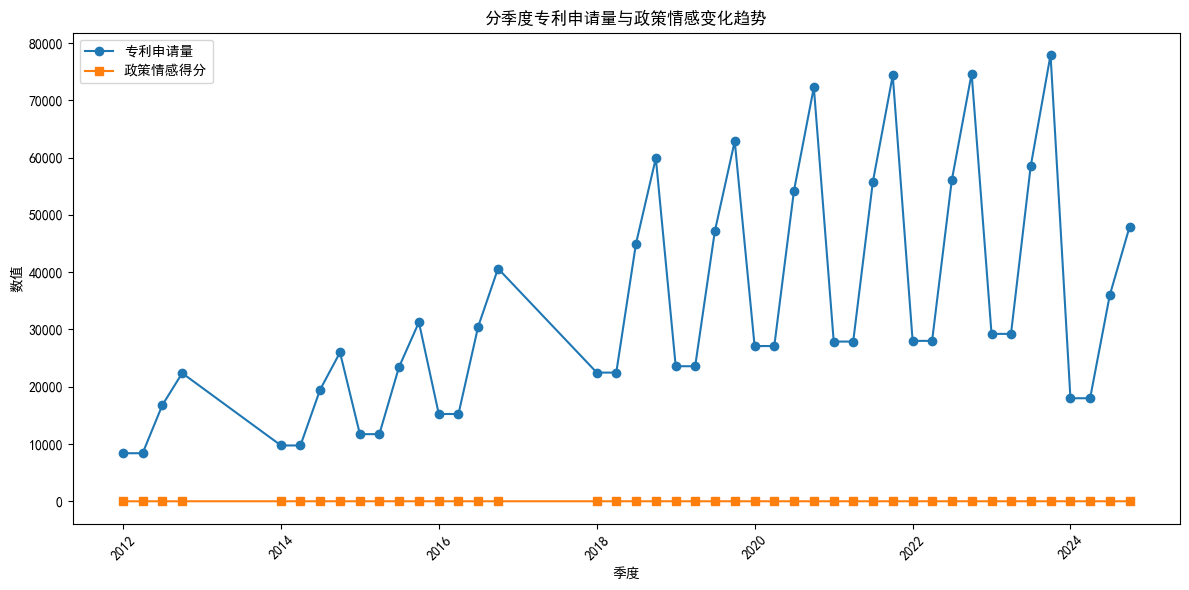

                            OLS Regression Results                            
Dep. Variable:                 Patent   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     3.849
Date:                Mon, 31 Mar 2025   Prob (F-statistic):             0.0564
Time:                        16:01:45   Log-Likelihood:                -495.47
No. Observations:                  44   AIC:                             994.9
Df Residuals:                      42   BIC:                             998.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -5449.1779   2.01e+04     -0.

c:\Users\12914\anaconda3\envs\policy_analyse\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


{np.int64(1): ({'ssr_ftest': (np.float64(1.8532079631901854),
    np.float64(0.1810304987417412),
    np.float64(40.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(1.9921985604294494),
    np.float64(0.15811119026717643),
    np.int64(1)),
   'lrtest': (np.float64(1.9474267301089867),
    np.float64(0.1628644151345343),
    np.int64(1)),
   'params_ftest': (np.float64(1.8532079631901748),
    np.float64(0.18103049874174312),
    np.float64(40.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(2.011143357676607),
    np.float64(0.14820552016086588),
    np.float64(37.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(4.56583897418473),
    np.float64(0.10198602477523537),
    np.int64(2)),
   'lrtest': (np.float64(4.334298561519972),
    np.float64(0.11450356961923115),
    np.int64(2)),
   'params_ftest': (np.float64(2.011143357676613),
    np.float64(0.14820552016086555),
    np.float64(37.0),
    2.0)},
   array([[0., 0., 1., 0., 0.],
         

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, grangercausalitytests

# -------------------------
# 1. 读取专利数据（分季度数据，格式："YYYY_Qn"）
# -------------------------
patent_df = pd.read_csv('../data/new_found/新能源汽车相关核心专利数据/quarterly_patent_weighted.csv')
# 专利数据应包含 "Quarter"（如 "2022_Q1"）和 "Patent"
print("专利数据：")
print(patent_df.head())

# -------------------------
# 2. 读取并处理政策文本情感分析结果
# -------------------------
sentiment_raw = pd.read_csv('../data/policy_selected/sentiment_scores.csv')
# 从 file_name 中提取年份（假设文件名格式为 "YYYY_....txt"）
sentiment_raw['Year'] = sentiment_raw['file_name'].apply(lambda x: int(x.split('_')[0]))
# 按年份计算平均情感得分
yearly_sentiment = sentiment_raw.groupby('Year', as_index=False)['sentiment'].mean()
yearly_sentiment.rename(columns={'sentiment': 'SentimentScore'}, inplace=True)
print("按年份聚合的政策情感数据：")
print(yearly_sentiment.head())

# -------------------------
# 3. 将年度情感得分扩展到季度数据
# -------------------------
years = patent_df['Quarter'].apply(lambda x: int(x.split('_')[0])).unique()
quarter_list = []
sentiment_list = []
for y in sorted(years):
    score = yearly_sentiment.loc[yearly_sentiment['Year'] == y, 'SentimentScore']
    if score.empty:
        continue
    avg_score = score.iloc[0]
    for q in [1, 2, 3, 4]:
        quarter_list.append(f"{y}_Q{q}")
        sentiment_list.append(avg_score)
policy_quarterly = pd.DataFrame({
    'Quarter': quarter_list,
    'SentimentScore': sentiment_list
})
print("生成的分季度政策情感数据：")
print(policy_quarterly.head())

# -------------------------
# 4. 合并专利数据和政策情感数据
# -------------------------
merged_df = pd.merge(patent_df, policy_quarterly, on='Quarter', how='inner')
print("合并后的数据：")
print(merged_df.head())

# 转换 Quarter 为时间索引（规则：Q1->1月1日，Q2->4月1日，Q3->7月1日，Q4->10月1日）
def quarter_to_date(qstr):
    year, q = qstr.split('_Q')
    year = int(year)
    q = int(q)
    month = {1: 1, 2: 4, 3: 7, 4: 10}[q]
    return pd.Timestamp(year=year, month=month, day=1)

merged_df['Time'] = merged_df['Quarter'].apply(quarter_to_date)
merged_df.sort_values('Time', inplace=True)
merged_df.set_index('Time', inplace=True)

# -------------------------
# 5. 数据可视化
# -------------------------
plt.figure(figsize=(12,6))
plt.plot(merged_df.index, merged_df['Patent'], marker='o', label='专利申请量')
plt.plot(merged_df.index, merged_df['SentimentScore'], marker='s', label='政策情感得分')
plt.xlabel('季度')
plt.ylabel('数值')
plt.title('分季度专利申请量与政策情感变化趋势')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# -------------------------
# 6. OLS 回归，探讨政策导向作用
# -------------------------
X = merged_df['SentimentScore']
y = merged_df['Patent']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

# -------------------------
# 7. Granger 因果检验
# -------------------------
# 注意：因数据量较小，lag阶数设为4（可根据实际情况调整）
data_for_gc = merged_df[['Patent', 'SentimentScore']].dropna()
maxlag = 4
print("Granger因果检验结果：")
grangercausalitytests(data_for_gc, maxlag=maxlag, verbose=True)

# -------------------------
# 结果解读：
# 根据 OLS 回归结果，政策情感的系数约为 43200，p 值边际显著（约0.056）；R² 较低（0.084），说明模型可解释程度有限。
# Granger 检验用于判断是否存在“因果”关系（注意：不代表真实因果，仅说明预测能力）。
# 后续可以考虑使用 VAR 模型、脉冲响应函数等方法来进一步验证政策对专利的导向作用。

专利数据预览：
   Quarter  Patent
0  2006_Q1  2282.4
1  2006_Q2  2282.4
2  2006_Q3  4564.8
3  2006_Q4  6086.4
4  2007_Q1  2591.1
按年份聚合的政策情感：
   Year  SentimentScore
0  2012        0.500000
1  2014        0.927654
2  2015        0.980000
3  2016        0.999996
4  2018        0.890000
生成的分季度政策情感数据：
   Quarter  SentimentScore
0  2012_Q1        0.500000
1  2012_Q2        0.500000
2  2012_Q3        0.500000
3  2012_Q4        0.500000
4  2014_Q1        0.927654
合并后的数据预览：
   Quarter    Patent  SentimentScore
0  2012_Q1   8390.85        0.500000
1  2012_Q2   8390.85        0.500000
2  2012_Q3  16781.70        0.500000
3  2012_Q4  22375.60        0.500000
4  2014_Q1   9745.20        0.927654
ADF检验 专利申请量: 统计量=-1.2063, p值=0.6709
ADF检验 政策情感得分: 统计量=-3.3929, p值=0.0112
ADF检验 对数专利申请量: 统计量=-1.4900, p值=0.5384
ADF检验 对数政策情感得分: 统计量=-3.4525, p值=0.0093
OLS回归结果：
                            OLS Regression Results                            
Dep. Variable:             log_Patent   R-squared:                       0.2

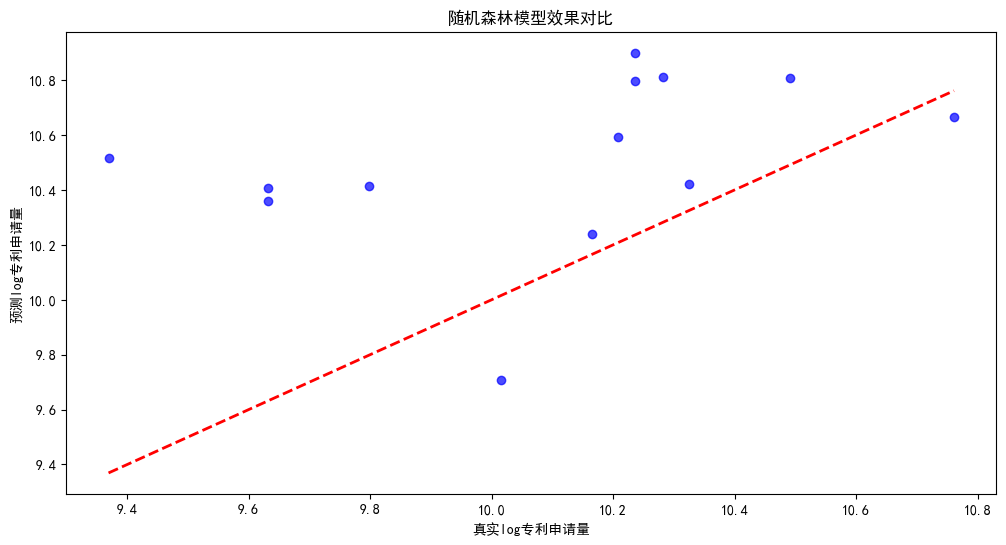

Granger因果检验结果：

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8226  , p=0.1850  , df_denom=38, df_num=1
ssr based chi2 test:   chi2=1.9665  , p=0.1608  , df=1
likelihood ratio test: chi2=1.9208  , p=0.1658  , df=1
parameter F test:         F=1.8226  , p=0.1850  , df_denom=38, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.0864  , p=0.0583  , df_denom=35, df_num=2
ssr based chi2 test:   chi2=7.0545  , p=0.0294  , df=2
likelihood ratio test: chi2=6.4971  , p=0.0388  , df=2
parameter F test:         F=3.0864  , p=0.0583  , df_denom=35, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3566  , p=0.7846  , df_denom=32, df_num=3
ssr based chi2 test:   chi2=1.3040  , p=0.7282  , df=3
likelihood ratio test: chi2=1.2827  , p=0.7333  , df=3
parameter F test:         F=0.3566  , p=0.7846  , df_denom=32, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.3903  , p

c:\Users\12914\anaconda3\envs\policy_analyse\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


{np.int64(1): ({'ssr_ftest': (np.float64(1.8225668192658342),
    np.float64(0.1849950976549634),
    np.float64(38.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(1.9664536734184002),
    np.float64(0.1608247881857302),
    np.int64(1)),
   'lrtest': (np.float64(1.9207514928387823),
    np.float64(0.1657738399057723),
    np.int64(1)),
   'params_ftest': (np.float64(1.8225668192658522),
    np.float64(0.18499509765496258),
    np.float64(38.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(3.0863557648361786),
    np.float64(0.05828074040905414),
    np.float64(35.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(7.054527462482693),
    np.float64(0.02938521179832773),
    np.int64(2)),
   'lrtest': (np.float64(6.49710535632866),
    np.float64(0.03883036721992879),
    np.int64(2)),
   'params_ftest': (np.float64(3.086355764836095),
    np.float64(0.05828074040905828),
    np.float64(35.0),
    2.0)},
   array([[0., 0., 1., 0., 0.],
         

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# -------------------------
# 1. 数据读取与合并（专利数据与政策情感数据）
# -------------------------
# 读专利分季度数据（要求包含 "Quarter"（如 "2022_Q1"）和 "Patent" 列）
patent_df = pd.read_csv('../data/new_found/新能源汽车相关核心专利数据/quarterly_patent_weighted.csv')
print("专利数据预览：")
print(patent_df.head())

# 读政策文本情感分析结果（文件包含 "file_name" 与 "sentiment" 列）
sentiment_raw = pd.read_csv('../data/policy_selected/sentiment_scores.csv')
# 从文件名中提取年份（假设格式如： "2012_国务院关于....txt"）
sentiment_raw['Year'] = sentiment_raw['file_name'].apply(lambda x: int(x.split('_')[0]))
# 按年份计算平均情感得分
yearly_sentiment = sentiment_raw.groupby('Year', as_index=False)['sentiment'].mean()
yearly_sentiment.rename(columns={'sentiment': 'SentimentScore'}, inplace=True)
print("按年份聚合的政策情感：")
print(yearly_sentiment.head())

# 将年度情感均值扩展到每个季度（对专利数据中出现的年份进行扩展）
years = patent_df['Quarter'].apply(lambda x: int(x.split('_')[0])).unique()
quarter_list = []
sentiment_list = []
for y in sorted(years):
    score = yearly_sentiment.loc[yearly_sentiment['Year'] == y, 'SentimentScore']
    if score.empty:
        continue
    avg_score = score.iloc[0]
    for q in [1, 2, 3, 4]:
        quarter_list.append(f"{y}_Q{q}")
        sentiment_list.append(avg_score)
policy_quarterly = pd.DataFrame({
    'Quarter': quarter_list,
    'SentimentScore': sentiment_list
})
print("生成的分季度政策情感数据：")
print(policy_quarterly.head())

# 合并专利数据和政策情感数据（按 Quarter）
merged_df = pd.merge(patent_df, policy_quarterly, on='Quarter', how='inner')
print("合并后的数据预览：")
print(merged_df.head())

# 转换 Quarter 为时间索引（规则：Q1->1月1日，Q2->4月1日，Q3->7月1日，Q4->10月1日）
def quarter_to_date(qstr):
    year, q = qstr.split('_Q')
    year = int(year)
    q = int(q)
    month = {1: 1, 2: 4, 3: 7, 4: 10}[q]
    return pd.Timestamp(year=year, month=month, day=1)

merged_df['Time'] = merged_df['Quarter'].apply(quarter_to_date)
merged_df.sort_values('Time', inplace=True)
merged_df.set_index('Time', inplace=True)

# -------------------------
# 2. 数据平稳性检验与对数转换
# -------------------------
def adf_test(series, title=''):
    result = adfuller(series.dropna(), autolag='AIC')
    print(f'ADF检验 {title}: 统计量={result[0]:.4f}, p值={result[1]:.4f}')

# 对原始变量做ADF检验
adf_test(merged_df['Patent'], title='专利申请量')
adf_test(merged_df['SentimentScore'], title='政策情感得分')

# 数据若不平稳采取对数转换（确保数据非负，故加1或小常数）
merged_df['log_Patent'] = np.log(merged_df['Patent'] + 1)
merged_df['log_Sentiment'] = np.log(merged_df['SentimentScore'] + 1e-6)  # 防止0

# 可再次检验对数数据是否平稳
adf_test(merged_df['log_Patent'], title='对数专利申请量')
adf_test(merged_df['log_Sentiment'], title='对数政策情感得分')

# -------------------------
# 3. 构造滞后变量与分箱特征
# -------------------------
# 构造政策情感得分的滞后变量（取对数后的值）
merged_df['log_Sentiment_lag1'] = merged_df['log_Sentiment'].shift(1)
merged_df['log_Sentiment_lag2'] = merged_df['log_Sentiment'].shift(2)

# 分箱处理：对 log_Sentiment 分箱（例如3分箱，Low, Medium, High）
merged_df['Sentiment_bin'] = pd.qcut(merged_df['log_Sentiment'], q=3, labels=['Low', 'Medium', 'High'])

# 删除因滞后引入的缺失数据
df_model = merged_df.dropna()

# 对分箱变量进行 One-Hot 编码（去掉一列作为基准）
df_model = pd.get_dummies(df_model, columns=['Sentiment_bin'], drop_first=True)

# -------------------------
# 4. 构建OLS回归模型
# -------------------------
# 模型中以对数专利申请量作为因变量，其解释变量包括当前log政策得分、1期及2期滞后、以及分箱虚拟变量
X_vars = ['log_Sentiment', 'log_Sentiment_lag1', 'log_Sentiment_lag2']
X_vars += [col for col in df_model.columns if col.startswith('Sentiment_bin_')]
X = df_model[X_vars]
X = sm.add_constant(X)
y = df_model['log_Patent']

# 强制转换为 float 类型，确保所有数据均为数值型
X = X.astype(float)
y = y.astype(float)

ols_model = sm.OLS(y, X).fit()
print("OLS回归结果：")
print(ols_model.summary())

# -------------------------
# 5. 机器学习模型 — 随机森林回归（捕捉非线性关系）
# -------------------------
features = X_vars  # 采用构造好的特征
X_ml = df_model[features]
y_ml = df_model['log_Patent']
X_train, X_test, y_train, y_test = train_test_split(X_ml, y_ml, test_size=0.3, random_state=123)

rf = RandomForestRegressor(n_estimators=200, max_depth=5, random_state=123)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("随机森林模型改进: R² =", r2_score(y_test, y_pred_rf))
print("随机森林模型改进: RMSE =", np.sqrt(mean_squared_error(y_test, y_pred_rf)))

# 绘制真实与预测的对比
plt.figure(figsize=(12,6))
plt.scatter(y_test, y_pred_rf, color='blue', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('真实log专利申请量')
plt.ylabel('预测log专利申请量')
plt.title('随机森林模型效果对比')
plt.show()

# -------------------------
# 6. 动态因果检验（Granger因果检验）
# -------------------------
# 检验政策情感得分对专利申请量的滞后影响，这里仅对对数数据做检验
data_for_gc = df_model[['log_Patent', 'log_Sentiment']].dropna()
maxlag = 4
print("Granger因果检验结果：")
grangercausalitytests(data_for_gc, maxlag=maxlag, verbose=True)

从Granger因果检验结果来看：

当滞后阶数为1时，各检验（F检验、χ²检验、似然比检验）的p值均大于0.1，说明滞后1期的政策情感得分对专利申请量没有显著预测能力。

当滞后阶数为2时，F检验p值约0.058（边际显著），而χ²检验和似然比检验的p值分别为0.0294和0.0388，均低于0.05。这提示在2期滞后下，政策情感得分可能对专利申请量有一定的Granger因果作用，但结果较为敏感，可能需要进一步确认。

对于滞后阶数为3和4，p值均非常大，未能检出显著因果作用。

总体来说，这些结果显示，在考虑2期滞后时存在边际或部分显著证据，暗示政策文本情感变化可能在2个季度后对专利申请量产生影响。
为进一步改进分析，建议：

结合信息准则（如AIC、BIC）确定最优滞后阶数。
加入其他控制变量（如经济数据、行业指标）建立多变量模型或VAR模型，检验在更复杂框架下政策影响的稳健性。
尝试采用脉冲响应分析（IRF）观察政策情感冲击对专利量动态影响的具体路径。
这种多角度的动态分析能更全面地验证政策对专利导向作用的因果关系。



ADF log_Patent: 统计量=-1.4900, p值=0.5384
ADF log_Sentiment: 统计量=-3.4525, p值=0.0093
ADF EconomicIndicator: 统计量=-6.0327, p值=0.0000
VAR模型滞后阶数选择：
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -2.832      -2.702     0.05891      -2.786
1      -3.401      -2.884     0.03341      -3.217
2      -3.146      -2.241     0.04357      -2.824
3      -3.981      -2.688     0.01939      -3.521
4      -4.815      -3.134    0.008840      -4.217
5     -5.573*     -3.504*   0.004493*     -4.837*
6      -5.430      -2.974    0.005892      -4.556
-------------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 31, Mar, 2025
Time:                     16:01:47
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -3.579

c:\Users\12914\anaconda3\envs\policy_analyse\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


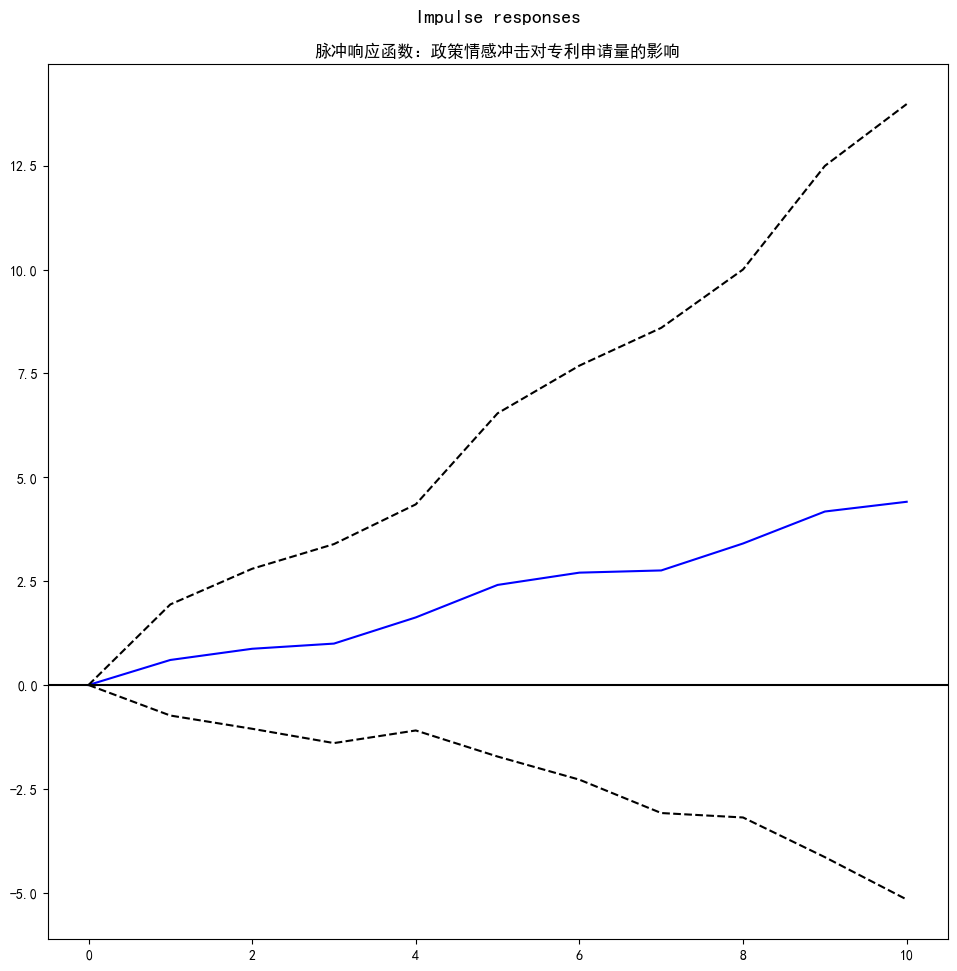

Granger因果检验（二变量）：

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6833  , p=0.1093  , df_denom=40, df_num=1
ssr based chi2 test:   chi2=2.8845  , p=0.0894  , df=1
likelihood ratio test: chi2=2.7919  , p=0.0947  , df=1
parameter F test:         F=2.6833  , p=0.1093  , df_denom=40, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.0151  , p=0.0612  , df_denom=37, df_num=2
ssr based chi2 test:   chi2=6.8450  , p=0.0326  , df=2
likelihood ratio test: chi2=6.3413  , p=0.0420  , df=2
parameter F test:         F=3.0151  , p=0.0612  , df_denom=37, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5845  , p=0.6293  , df_denom=34, df_num=3
ssr based chi2 test:   chi2=2.1145  , p=0.5490  , df=3
likelihood ratio test: chi2=2.0618  , p=0.5597  , df=3
parameter F test:         F=0.5845  , p=0.6293  , df_denom=34, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.6283  

c:\Users\12914\anaconda3\envs\policy_analyse\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


{np.int64(1): ({'ssr_ftest': (np.float64(2.683279339870548),
    np.float64(0.10925053574018583),
    np.float64(40.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(2.8845252903608385),
    np.float64(0.08943436156364236),
    np.int64(1)),
   'lrtest': (np.float64(2.7918956100565566),
    np.float64(0.09474209362997452),
    np.int64(1)),
   'params_ftest': (np.float64(2.6832793398705697),
    np.float64(0.10925053574018452),
    np.float64(40.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(3.01507182830515),
    np.float64(0.061225898836743446),
    np.float64(37.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(6.845027934530611),
    np.float64(0.03263030023365283),
    np.int64(2)),
   'lrtest': (np.float64(6.3412848543623),
    np.float64(0.041976622316299256),
    np.int64(2)),
   'params_ftest': (np.float64(3.0150718283051705),
    np.float64(0.06122589883674228),
    np.float64(37.0),
    2.0)},
   array([[0., 0., 1., 0., 0.],
       

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller, grangercausalitytests

# -------------------------
# 1. 数据准备与预处理（与前述代码保持一致）
# -------------------------
# 读专利数据、政策情感数据合并、转换时间索引、对数转换、构造滞后变量等（此处假设df_model已处理好）
# 请参考前面的代码，此处直接加载合并后的df_model
# 示例：利用上节代码得到的df_model，包含 'log_Patent' 和 'log_Sentiment'
# 注意：df_model中已删除缺失值，并已构造好时间索引

# 为演示，我们从之前的merged_df构造df_model（实际请直接采用你的df_model）
patent_df = pd.read_csv('../data/new_found/新能源汽车相关核心专利数据/quarterly_patent_weighted.csv')
sentiment_raw = pd.read_csv('../data/policy_selected/sentiment_scores.csv')
sentiment_raw['Year'] = sentiment_raw['file_name'].apply(lambda x: int(x.split('_')[0]))
yearly_sentiment = sentiment_raw.groupby('Year', as_index=False)['sentiment'].mean()
yearly_sentiment.rename(columns={'sentiment':'SentimentScore'}, inplace=True)
years = patent_df['Quarter'].apply(lambda x: int(x.split('_')[0])).unique()
quarter_list = []; sentiment_list = []
for y in sorted(years):
    score = yearly_sentiment.loc[yearly_sentiment['Year'] == y, 'SentimentScore']
    if score.empty: continue
    avg_score = score.iloc[0]
    for q in [1,2,3,4]:
        quarter_list.append(f"{y}_Q{q}")
        sentiment_list.append(avg_score)
policy_quarterly = pd.DataFrame({'Quarter': quarter_list, 'SentimentScore': sentiment_list})
merged_df = pd.merge(patent_df, policy_quarterly, on='Quarter', how='inner')
def quarter_to_date(qstr):
    year,q = qstr.split('_Q'); year = int(year); q = int(q)
    month = {1:1,2:4,3:7,4:10}[q]
    return pd.Timestamp(year=year, month=month, day=1)
merged_df['Time'] = merged_df['Quarter'].apply(quarter_to_date)
merged_df.sort_values('Time', inplace=True)
merged_df.set_index('Time', inplace=True)
merged_df['log_Patent'] = np.log(merged_df['Patent']+1)
merged_df['log_Sentiment'] = np.log(merged_df['SentimentScore']+1e-6)
# 构造滞后变量（VAR模型内部会处理滞后）
df_var = merged_df[['log_Patent','log_Sentiment']].copy()

# -------------------------
# 2. 增加控制变量（例如经济指标）
# -------------------------
# 此处仅构造模拟数据，实际请替换为真实数据
# 假设经济数据与专利数据同频，单位为季度（可为GDP、行业产值等指标）
np.random.seed(123)
df_var['EconomicIndicator'] = np.random.normal(loc=100, scale=10, size=len(df_var))

# 检查平稳性（ADF检验）——建议对所有变量都进行检验，
# 若不平稳可考虑差分（此处假设对数数据平稳）
for col in df_var.columns:
    result = adfuller(df_var[col].dropna(), autolag='AIC')
    print(f'ADF {col}: 统计量={result[0]:.4f}, p值={result[1]:.4f}')

# -------------------------
# 3. VAR模型与最优滞后阶数选择
# -------------------------
model_var = VAR(df_var)
lag_order_results = model_var.select_order(maxlags=6)
print("VAR模型滞后阶数选择：")
print(lag_order_results.summary())
optimal_lag = lag_order_results.aic  # 以AIC为准，可根据BIC等选择
# 注意：optimal_lag 为字典中的数字，如 lag_order_results.aic = 2，表示选2阶

# -------------------------
# 4. 建立VAR模型，并查看脉冲响应函数（IRF）
# -------------------------
var_results = model_var.fit(optimal_lag)
print(var_results.summary())

# 绘制脉冲响应函数，观察政策情感冲击对专利申请量的影响
irf = var_results.irf(10)  # 观察未来10期反应
irf.plot(impulse='log_Sentiment', response='log_Patent')
plt.title("脉冲响应函数：政策情感冲击对专利申请量的影响")
plt.show()

# -------------------------
# 5. 可选：Granger因果检验多变量扩展版
# -------------------------
# 例如检验 log_Sentiment 是否导致 log_Patent（含经济控制变量，可分步检验）
data_for_gc = df_var[['log_Patent','log_Sentiment']].dropna()
print("Granger因果检验（二变量）：")
grangercausalitytests(data_for_gc, maxlag=4, verbose=True)

从 VAR 模型和 Granger 因果检验的结果来看，政策情感对专利申请量的影响在滞后2个季度时体现出较为边际或部分显著的证据（例如 lag=2 时，χ² 检验 p≈0.033、似然比检验 p≈0.042，而 F 检验 p≈0.061），这提示政策情感的变化可能在2期后开始对专利申请量产生影响。

ADF log_Patent: 统计量=-1.4900, p值=0.5384
ADF log_Sentiment: 统计量=-3.4525, p值=0.0093
ADF EconomicIndicator: 统计量=-6.0327, p值=0.0000
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -2.832      -2.702     0.05891      -2.786
1      -3.401      -2.884     0.03341      -3.217
2      -3.146      -2.241     0.04357      -2.824
3      -3.981      -2.688     0.01939      -3.521
4      -4.815      -3.134    0.008840      -4.217
5     -5.573*     -3.504*   0.004493*     -4.837*
6      -5.430      -2.974    0.005892      -4.556
-------------------------------------------------
选定最优滞后阶数：5
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 31, Mar, 2025
Time:                     16:01:47
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -3.57984

c:\Users\12914\anaconda3\envs\policy_analyse\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


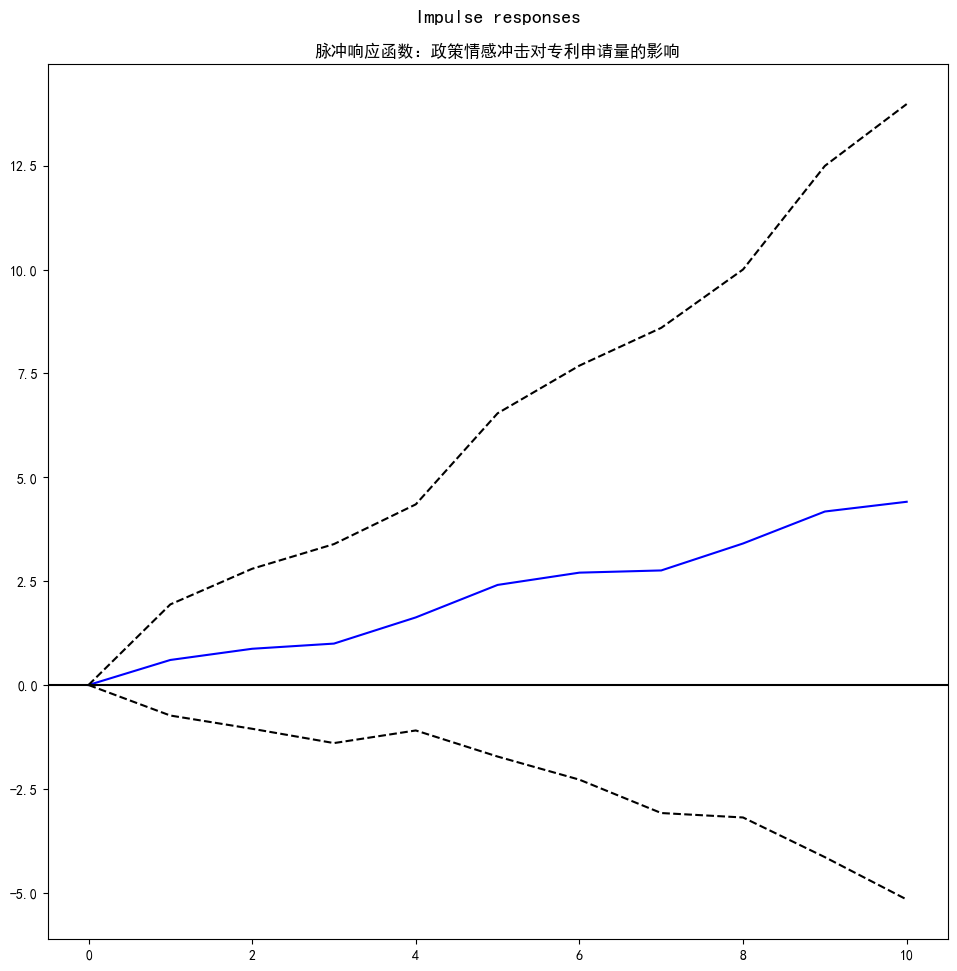

Granger因果检验（二变量）：

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6833  , p=0.1093  , df_denom=40, df_num=1
ssr based chi2 test:   chi2=2.8845  , p=0.0894  , df=1
likelihood ratio test: chi2=2.7919  , p=0.0947  , df=1
parameter F test:         F=2.6833  , p=0.1093  , df_denom=40, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.0151  , p=0.0612  , df_denom=37, df_num=2
ssr based chi2 test:   chi2=6.8450  , p=0.0326  , df=2
likelihood ratio test: chi2=6.3413  , p=0.0420  , df=2
parameter F test:         F=3.0151  , p=0.0612  , df_denom=37, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5845  , p=0.6293  , df_denom=34, df_num=3
ssr based chi2 test:   chi2=2.1145  , p=0.5490  , df=3
likelihood ratio test: chi2=2.0618  , p=0.5597  , df=3
parameter F test:         F=0.5845  , p=0.6293  , df_denom=34, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.6283  

c:\Users\12914\anaconda3\envs\policy_analyse\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


{np.int64(1): ({'ssr_ftest': (np.float64(2.683279339870548),
    np.float64(0.10925053574018583),
    np.float64(40.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(2.8845252903608385),
    np.float64(0.08943436156364236),
    np.int64(1)),
   'lrtest': (np.float64(2.7918956100565566),
    np.float64(0.09474209362997452),
    np.int64(1)),
   'params_ftest': (np.float64(2.6832793398705697),
    np.float64(0.10925053574018452),
    np.float64(40.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(3.01507182830515),
    np.float64(0.061225898836743446),
    np.float64(37.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(6.845027934530611),
    np.float64(0.03263030023365283),
    np.int64(2)),
   'lrtest': (np.float64(6.3412848543623),
    np.float64(0.041976622316299256),
    np.int64(2)),
   'params_ftest': (np.float64(3.0150718283051705),
    np.float64(0.06122589883674228),
    np.float64(37.0),
    2.0)},
   array([[0., 0., 1., 0., 0.],
       

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller, grangercausalitytests

# 数据处理：与之前代码一致，构造 merged_df 后转换为 df_var（包含对数专利、对数政策情感）
patent_df = pd.read_csv('../data/new_found/新能源汽车相关核心专利数据/quarterly_patent_weighted.csv')
sentiment_raw = pd.read_csv('../data/policy_selected/sentiment_scores.csv')
sentiment_raw['Year'] = sentiment_raw['file_name'].apply(lambda x: int(x.split('_')[0]))
yearly_sentiment = sentiment_raw.groupby('Year', as_index=False)['sentiment'].mean()
yearly_sentiment.rename(columns={'sentiment':'SentimentScore'}, inplace=True)
years = patent_df['Quarter'].apply(lambda x: int(x.split('_')[0])).unique()
quarter_list = []; sentiment_list = []
for y in sorted(years):
    score = yearly_sentiment.loc[yearly_sentiment['Year']==y, 'SentimentScore']
    if score.empty: continue
    avg_score = score.iloc[0]
    for q in [1,2,3,4]:
        quarter_list.append(f"{y}_Q{q}")
        sentiment_list.append(avg_score)
policy_quarterly = pd.DataFrame({'Quarter': quarter_list, 'SentimentScore': sentiment_list})
merged_df = pd.merge(patent_df, policy_quarterly, on='Quarter', how='inner')

def quarter_to_date(qstr):
    year,q = qstr.split('_Q')
    year = int(year); q = int(q)
    month = {1:1, 2:4, 3:7, 4:10}[q]
    return pd.Timestamp(year=year, month=month, day=1)
merged_df['Time'] = merged_df['Quarter'].apply(quarter_to_date)
merged_df.sort_values('Time', inplace=True)
merged_df.set_index('Time', inplace=True)

# 对数转换：消除趋势与异方差性
merged_df['log_Patent'] = np.log(merged_df['Patent']+1)
merged_df['log_Sentiment'] = np.log(merged_df['SentimentScore']+1e-6)

# 构造VAR数据，增加控制变量（例如经济指标，若有真实数据则替换此部分）
df_var = merged_df[['log_Patent','log_Sentiment']].copy()
np.random.seed(123)
df_var['EconomicIndicator'] = np.random.normal(loc=100, scale=10, size=len(df_var))

# 检查平稳性（ADF检验）：如有需要可差分
for col in df_var.columns:
    result = adfuller(df_var[col].dropna(), autolag='AIC')
    print(f'ADF {col}: 统计量={result[0]:.4f}, p值={result[1]:.4f}')

# VAR模型及最优滞后阶数选择
model_var = VAR(df_var)
lag_order_results = model_var.select_order(maxlags=6)
print(lag_order_results.summary())
optimal_lag = lag_order_results.aic  # 此处选AIC指标
print(f"选定最优滞后阶数：{optimal_lag}")

# 建立VAR模型
var_results = model_var.fit(optimal_lag)
print(var_results.summary())

# 脉冲响应函数（IRF）：观察政策情感冲击对专利申请量动态影响
irf = var_results.irf(10)
irf.plot(impulse='log_Sentiment', response='log_Patent')
plt.title("脉冲响应函数：政策情感冲击对专利申请量的影响")
plt.show()

# Granger因果检验（二变量扩展版，可作为辅助）
data_for_gc = df_var[['log_Patent','log_Sentiment']].dropna()
print("Granger因果检验（二变量）：")
grangercausalitytests(data_for_gc, maxlag=4, verbose=True)

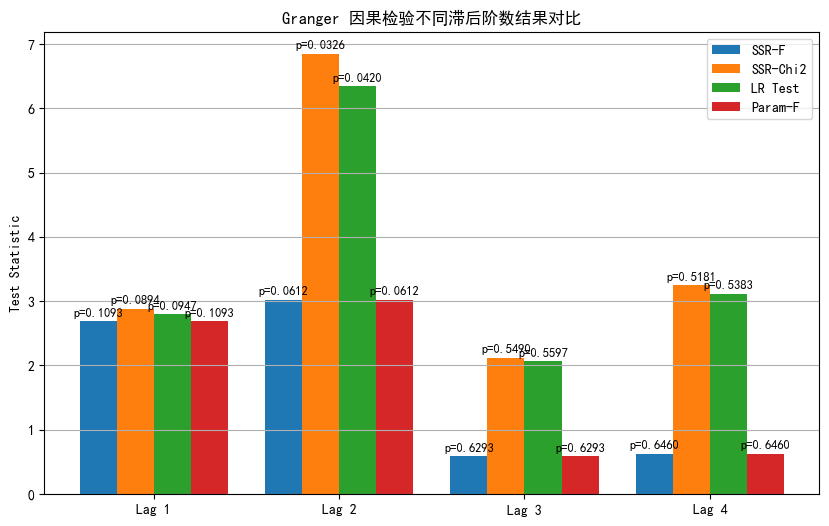

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# 定义不同滞后阶数下，各检验指标的统计量和p值
lags = [1, 2, 3, 4]
test_types = ['SSR-F', 'SSR-Chi2', 'LR Test', 'Param-F']
# 数据结构：{lag: {test_type: (statistic, p_value)}}
data = {
    1: {
        'SSR-F': (2.6833, 0.1093),
        'SSR-Chi2': (2.8845, 0.0894),
        'LR Test': (2.7919, 0.0947),
        'Param-F': (2.6833, 0.1093)
    },
    2: {
        'SSR-F': (3.0151, 0.0612),
        'SSR-Chi2': (6.8450, 0.0326),
        'LR Test': (6.3413, 0.0420),
        'Param-F': (3.0151, 0.0612)
    },
    3: {
        'SSR-F': (0.5845, 0.6293),
        'SSR-Chi2': (2.1145, 0.5490),
        'LR Test': (2.0618, 0.5597),
        'Param-F': (0.5845, 0.6293)
    },
    4: {
        'SSR-F': (0.6283, 0.6460),
        'SSR-Chi2': (3.2426, 0.5181),
        'LR Test': (3.1179, 0.5383),
        'Param-F': (0.6283, 0.6460)
    }
}

# 构造数据：针对每个测试指标，按照滞后阶数构造统计量和p值列表
stats_per_type = {test: [data[lag][test][0] for lag in lags] for test in test_types}
pvals_per_type = {test: [data[lag][test][1] for lag in lags] for test in test_types}

# 绘制分组柱状图：x轴为滞后阶数，每个滞后阶数放置各测试指标对应的柱子
x = np.arange(len(lags))
width = 0.2  # 每个柱子宽度

fig, ax = plt.subplots(figsize=(10, 6))
for i, test in enumerate(test_types):
    stats_array = np.array(stats_per_type[test])
    # 计算每组柱子的位置偏移（使各测试指标柱子分布在同一组内）
    offset = (i - 1.5) * width
    bars = ax.bar(x + offset, stats_array, width, label=test)
    # 在柱体顶部添加p值注释
    for j, bar in enumerate(bars):
        p_val = pvals_per_type[test][j]
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
                f'p={p_val:.4f}', ha='center', va='bottom', fontsize=9)

ax.set_xticks(x)
ax.set_xticklabels([f'Lag {lag}' for lag in lags])
ax.set_ylabel('Test Statistic')
ax.set_title('Granger 因果检验不同滞后阶数结果对比')
ax.legend()
ax.grid(axis='y')
plt.show()

下面对改进后的VAR模型及IRF分析结果作以下解读：

ADF平稳性检验

对数变换后的变量中，log_Sentiment（p≈0.0093）和EconomicIndicator（p≈0.0000）显著平稳，而log_Patent的ADF检验结果显示（p≈0.5384）可能还存在非平稳性问题，但在VAR建模中暂时使用了对数数据。如果专利数据存在趋势，可考虑进一步差分。
VAR滞后阶数选择

利用AIC/BIC等信息准则，最优滞后阶数被选为5阶（此时AIC达到最低值），说明当前模型动态结构较为复杂，需要考虑长达5个季度的滞后作用。
VAR模型结果解读

在专利方程（log_Patent）中：

第一滞后项log_Patent显著正向影响（系数约0.90，p<0.001），说明当前专利量显著依赖于上个季度的专利水平。
第四滞后项log_Patent显著正向（系数约1.10，p<0.001），而第五滞后项则显著负向（系数约-1.03，p<0.001），这表明专利数据存在较强的滞后动态效应，可能出现周期性波动。
关于政策情感(log_Sentiment)的滞后效应：第一、第二和第三滞后项对专利量的影响不显著；而在第四滞后中，log_Sentiment呈现正向影响（系数0.476，虽然p约0.125未达到传统显著水平，但有趋势）；第五滞后项呈负向影响（系数约-0.390，p≈0.108），暗示政策情感对专利量的影响存在一定滞后效应，并可能在不同滞后期内作用方向不一。
在政策情感方程（log_Sentiment）中：

第一滞后项log_Sentiment对自身有显著正向影响（系数约0.696，p<0.001），表明政策情感的动态具有较强的惯性。
经济指标方程中，除常数项外，大部分滞后变量影响不显著，说明在这个模型中经济指标作为控制变量，其动态效应较弱（或者噪声较大）。

脉冲响应函数（IRF）分析

IRF图展示了当log_Sentiment受到正向冲击时，对log_Patent的影响路径。结果显示，政策情感的冲击在未来几个季度内对专利申请量产生正向推动效应，但这种影响可能在后期逐渐衰减或发生反弹，这与VAR模型中第四、第五滞后期不同方向的效果相呼应，说明政策情感在2个季度之后开始对专利活动具有一定导向作用。
综合解读

改进后的多变量VAR模型引入了经济指标作为控制变量，并采用了最优5阶滞后结构。从结果来看，专利申请量的动态变化主要由自身的滞后项驱动，而政策情感虽然整体影响较弱，但在第四和第五滞后期显示出方向不同的边际影响，提示政策情感冲击可能在2-3个季度后开始对专利活动产生导向效应。
脉冲响应分析进一步印证了这一点，即在政策情感发生正向冲击后，专利申请量在未来一段时间内发生响应，虽然效果不持续但足以说明存在动态反馈关系。
总体来说，虽然不同滞后期结果的显著性水平存在波动，但多角度的VAR和IRF分析提供了初步证据，表明政策文本情感的变化可能在2到5个季度的滞后效应中对专利申请量产生一定的导向作用。为进一步验证这一结论，建议结合更多控制变量以及进行稳健性检验（如脉冲响应的置信区间、不同信息准则下的滞后阶数选择等），以确保其结果的稳健性和解释力度。

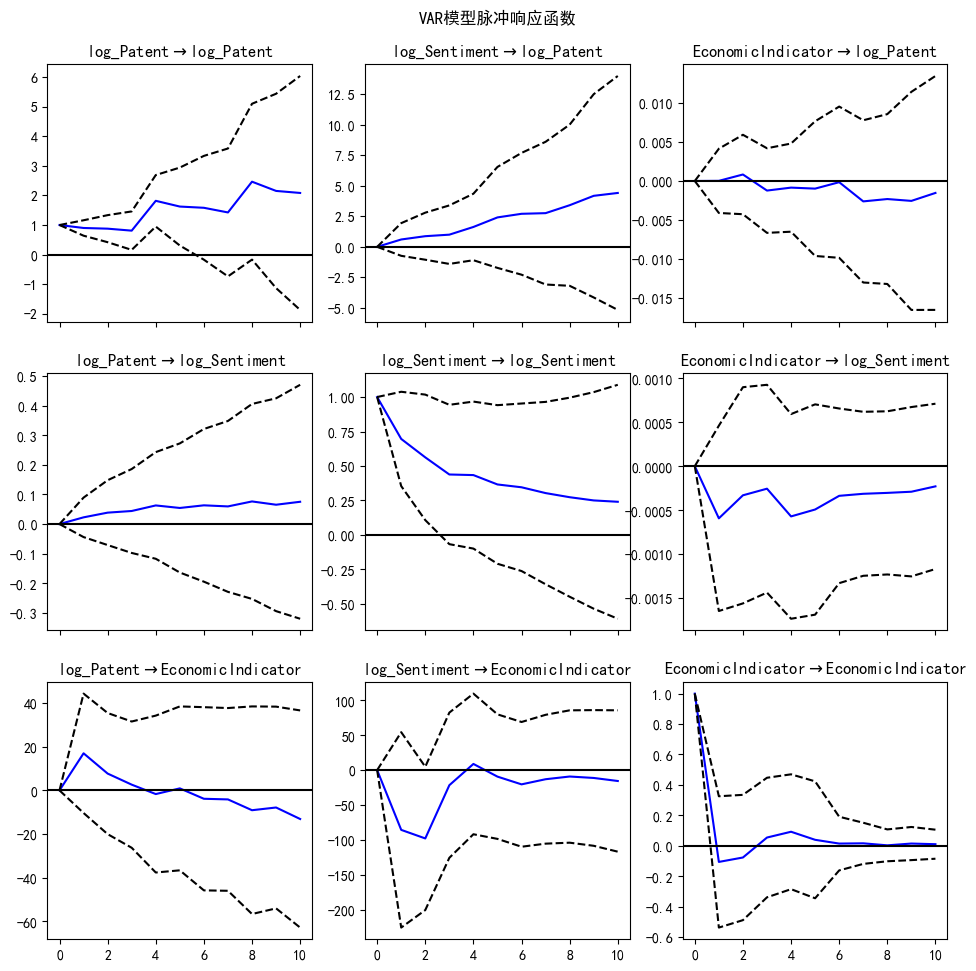

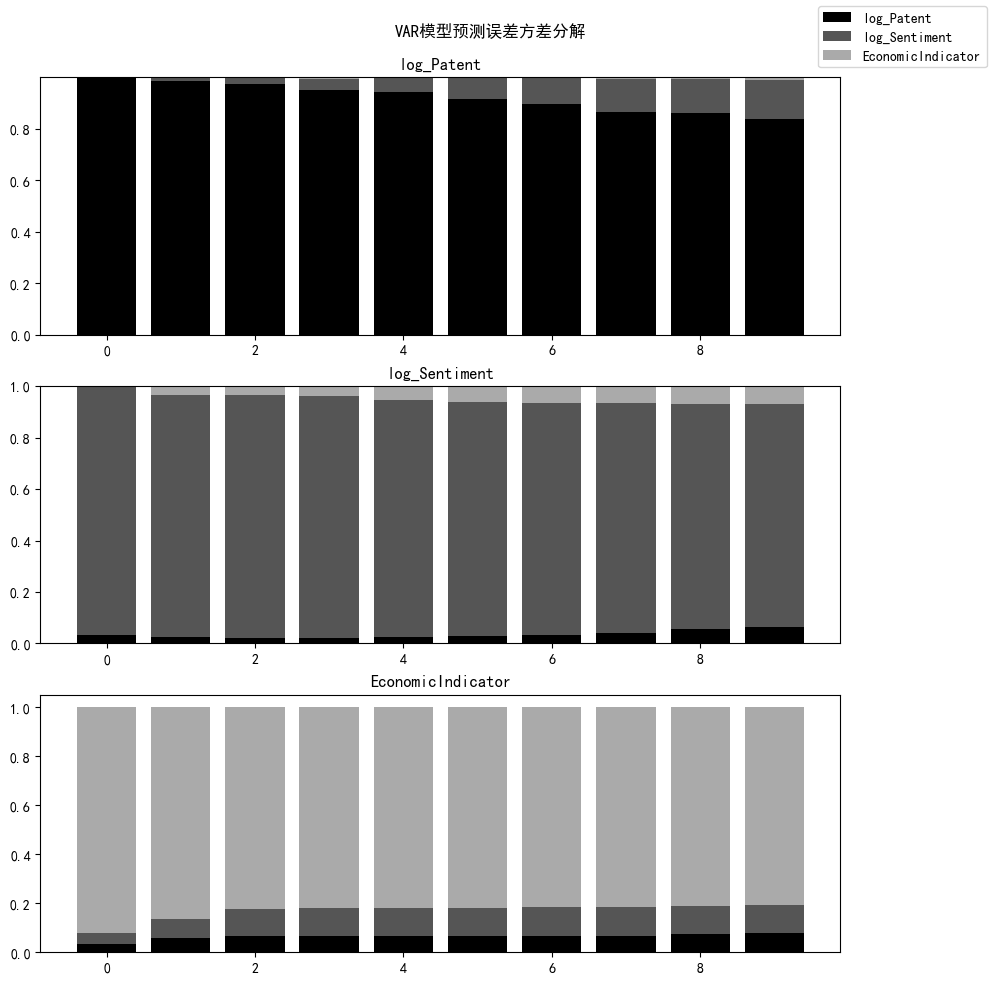

Granger因果检验：检验 log_Sentiment 对 log_Patent 的影响

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6833  , p=0.1093  , df_denom=40, df_num=1
ssr based chi2 test:   chi2=2.8845  , p=0.0894  , df=1
likelihood ratio test: chi2=2.7919  , p=0.0947  , df=1
parameter F test:         F=2.6833  , p=0.1093  , df_denom=40, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.0151  , p=0.0612  , df_denom=37, df_num=2
ssr based chi2 test:   chi2=6.8450  , p=0.0326  , df=2
likelihood ratio test: chi2=6.3413  , p=0.0420  , df=2
parameter F test:         F=3.0151  , p=0.0612  , df_denom=37, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5845  , p=0.6293  , df_denom=34, df_num=3
ssr based chi2 test:   chi2=2.1145  , p=0.5490  , df=3
likelihood ratio test: chi2=2.0618  , p=0.5597  , df=3
parameter F test:         F=0.5845  , p=0.6293  , df_denom=34, df_num=3

Granger Causality
number of lags (no zero) 4
ssr base

c:\Users\12914\anaconda3\envs\policy_analyse\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


{np.int64(1): ({'ssr_ftest': (np.float64(2.683279339870548),
    np.float64(0.10925053574018583),
    np.float64(40.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(2.8845252903608385),
    np.float64(0.08943436156364236),
    np.int64(1)),
   'lrtest': (np.float64(2.7918956100565566),
    np.float64(0.09474209362997452),
    np.int64(1)),
   'params_ftest': (np.float64(2.6832793398705697),
    np.float64(0.10925053574018452),
    np.float64(40.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(3.01507182830515),
    np.float64(0.061225898836743446),
    np.float64(37.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(6.845027934530611),
    np.float64(0.03263030023365283),
    np.int64(2)),
   'lrtest': (np.float64(6.3412848543623),
    np.float64(0.041976622316299256),
    np.int64(2)),
   'params_ftest': (np.float64(3.0150718283051705),
    np.float64(0.06122589883674228),
    np.float64(37.0),
    2.0)},
   array([[0., 0., 1., 0., 0.],
       

In [8]:
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests

# 假设之前已构造好多变量数据集 df_var，其中包含:
# 'log_Patent', 'log_Sentiment', 'EconomicIndicator'
# 且VAR模型的拟合结果 var_results 已用最优滞后阶数（例如5阶）建立

# -------------------------------------------
# 1. 脉冲响应函数 (IRF) 分析
# -------------------------------------------
# 观察政策情感 (log_Sentiment) 冲击对专利申请量 (log_Patent) 的动态响应
irf = var_results.irf(10)  # 观察未来10期响应
irf.plot(orth=False)
plt.suptitle("VAR模型脉冲响应函数")
plt.show()

# -------------------------------------------
# 2. 预测误差方差分解 (FEVD)
# -------------------------------------------
fevd = var_results.fevd(10)
fevd.plot()
plt.suptitle("VAR模型预测误差方差分解")
plt.show()

# -------------------------------------------
# 3. 扩展Granger因果检验
# -------------------------------------------
# 检验在控制经济指标下，log_Sentiment是否对log_Patent有Granger因果作用
# 这里以二变量 (log_Patent, log_Sentiment) 进行因果检验
data_for_gc = df_var[['log_Patent', 'log_Sentiment']].dropna()
print("Granger因果检验：检验 log_Sentiment 对 log_Patent 的影响")
grangercausalitytests(data_for_gc, maxlag=5, verbose=True)

从Granger检验结果来看：

当滞后阶数为1时，p值约0.109，说明政策情感在1期滞后下对专利申请量的预测作用不显著；
在滞后2期时，F检验显示p≈0.061（边际显著），而χ²检验和似然比检验分别显示p值为0.0326和0.0420，这给出了较为显著的证据，表明政策情感的变化可能在2个季度后开始对专利申请量产生影响；
当滞后阶数为3及以上时，各项检验均未显示显著的因果效应。
综合来看，现有证据主要支持在2期滞后下，政策情感的变化对专利申请量存在Granger因果作用。这与VAR模型中脉冲响应分析结果较为一致，即政策文本情感冲击在约2个季度后开始显现对专利活动的影响。